# Recommender System Based on Product Image

## Description
- In this project I developed a method for identifiying the similar products visually. The taks was implementing an algorithm to find k most similar images to given(original) product and display it to user.

# Data
- The main dataset is 2184 color images (150x150x3) with 7 brands and 10 products, and the file with labels style.csv. Photo files are in the .png format and the labels are integers and values. It is downloaded from [kaggle](https://www.kaggle.com/olgabelitskaya/style-color-images). 

# High Level Overview on the Algorithm
---

### Feature Extraction
- We need to `extract` the images features using CNN model. We dont have to train our model, we can make a use of Transfer Learning. In this project I used VGG16. VGG16 is a (16) convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. 


![VGG16](https://images.squarespace-cdn.com/content/v1/5a2de417914e6b4aaeea995b/1525872902098-QW6NRHPM5ZLJIM5PSRF2/ke17ZwdGBToddI8pDm48kOoZH-sodpzcMRRauuCS1UkUqsxRUqqbr1mOJYKfIPR7LoDQ9mXPOjoJoqy81S2I8N_N4V1vUb5AoIIIbLZhVYy7Mythp_T-mtop-vrsUOmeInPi9iDjx9w8K4ZfjXt2duvkIE4SzlVg1IA40TSl2Iz7vx7ZI2AaZCvRLajMU_LSpC969RuPXvt2ZwyzUXQf7Q/VGG16-2.jpg?format=1500w)

### Calculate the Similarity Score
- Once we have the image features, we can calculate the similarity score among all images. I used `cosine_similarity` score from `sklearn metrics package`. Cosine similariry metrics is widely-used when finding a similarty score between two vectors. Once we calculate the cosine similarity score, we can store it in csv file so we can later sort and use the closer score and images.

### Return K most similar items to chosen product.
- In this step all we do is sort the cosine similarity score dataframe, and return k most similar products which has higher score(closer to original product).

#### Step 1 Importing packages and setup the parameters
---

In [37]:
from keras.models import Model
from keras.applications import vgg16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

import os
import numpy as np
import pandas as pd
from PIL import Image
# to visualize the images
import matplotlib.pyplot as plt


In [48]:
root_dir = "data/images/"

# imgs_path = root_dir
imgs_model_width, imgs_model_height = 224, 224

k_similar = 5 # number of most similar images to retrieve

#### Initilize the model and remove the last year, because we only need the features not the prediction

In [49]:
vgg_model = vgg16.VGG16(weights='imagenet')

# ignore the last layer
feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feature_extractor.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

#### Read all image ids and store them in the list

In [50]:
def get_all_image_ids(filepath):
    """
    Get all image file names from dataset.
    
    Args:
        filepath(str): Root file path to images
        
    Returns:
        image_ids(list): list of all image ids
    """
    image_ids = []
    # listing all the image names into list they are ids of the image
    for img in os.listdir(filepath):
        if img.endswith('png'):
            image_ids.append(img)
    
    return image_ids


In [51]:
all_image_ids = get_all_image_ids(root_dir)
print("number of images:",len(all_image_ids))
print(all_image_ids[0])

number of images: 2184
6_0_003.png


In [52]:
#### Now we can visualize the image in our dataset

In [53]:
# load an image in PIL format
def display_image(filepath, image_id):
    """Displays the given image id from folder"""
    filename = filepath + image_id
    original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()
    # TODO: display item label
    print("image loaded successfully!")

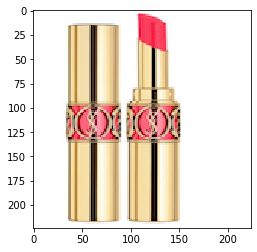

image loaded successfully!


In [54]:
display_image(root_dir, all_image_ids[10])

#### Extracting Image Features:
1. Preprocessing the image for vgg
1. Extract the image feature using vgg

In [55]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [56]:
# get the extracted features
img_features = feature_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

features successfully extracted!
number of image features: 4096


array([[0.        , 0.        , 0.        , ..., 0.16508457, 0.        ,
        0.774067  ]], dtype=float32)

#### Now We can extract image feature for all images.

In [60]:
def process_image_for_feature_extraction(filepath, all_image_ids):
    """
        Takes an image and returns 4D array of features from vgg16 model

        Args:
            image_path: path to image
    """

    # load all the images and prepare them for feeding into the CNN

    imported_images = []

    for image_id in all_image_ids:
        filename = filepath + image_id
        original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
        numpy_image = img_to_array(original)
        image_batch = np.expand_dims(numpy_image, axis=0)

        imported_images.append(image_batch)

    images = np.vstack(imported_images)

    processed_imgs = preprocess_input(images.copy())
    
    return processed_imgs


In [61]:
# extract the images features
processed_imgs = process_image_for_feature_extraction(root_dir, all_image_ids)


In [62]:
all_image_features = feature_extractor.predict(processed_imgs)

print("features successfully extracted!")
all_image_features.shape

features successfully extracted!


(2184, 4096)

#### Compute cosine similarities between images

In [64]:
def create_cosine_similarity_table(image_features, image_ids):
    # print(len(all_image_ids))
    cos_sims = cosine_similarity(image_features)

    # store the results into a pandas dataframe

    cos_sims_df = pd.DataFrame(cos_sims, columns=image_ids, index=image_ids)
    # store it in csv file
    #
#     cos_sims_df.to_csv('cos_sim_table_2154_images.csv', sep='\t', encoding='utf-8')
    
    return cos_sims_df
    

In [67]:
cos_sim_df = create_cosine_similarity_table(all_image_features, all_image_ids)

In [83]:
cos_sim_df.tail(10)

,6_0_003.png,1_6_022.png,6_0_017.png,4_3_008.png,3_5_015.png,4_3_020.png,3_5_001.png,5_0_037.png,6_1_012.png,2_6_002.png,...,3_5_024.png,3_8_013.png,4_3_011.png,3_8_007.png,4_3_005.png,6_0_032.png,1_6_007.png,1_6_013.png,6_0_026.png,4_5_040.png
3_5_024.png,0.240589,0.364141,0.214745,0.219258,0.364642,0.310858,0.393991,0.181397,0.201179,0.127768,...,1.000000,0.208074,0.205182,0.219755,0.143329,0.248050,0.214998,0.427820,0.301304,0.447388
3_8_013.png,0.494327,0.252816,0.430328,0.243954,0.328726,0.222687,0.355931,0.287082,0.212020,0.258739,...,0.208074,1.000000,0.255549,0.496543,0.221911,0.541525,0.271010,0.300146,0.432965,0.199743
4_3_011.png,0.187345,0.290965,0.212879,0.253297,0.383658,0.377547,0.284988,0.192636,0.326088,0.222262,...,0.205182,0.255549,1.000000,0.278035,0.230092,0.315116,0.285357,0.238391,0.297766,0.209442
3_8_007.png,0.471302,0.325775,0.417788,0.261905,0.337313,0.351808,0.423896,0.324839,0.201862,0.212886,...,0.219755,0.496543,0.278035,1.000000,0.190150,0.563893,0.412928,0.275419,0.437807,0.179772
4_3_005.png,0.154504,0.187361,0.197296,0.735227,0.291866,0.307429,0.252270,0.205137,0.218097,0.182119,...,0.143329,0.221911,0.230092,0.190150,1.000000,0.186734,0.206121,0.216983,0.334996,0.162455
6_0_032.png,0.498736,0.255963,0.562664,0.200664,0.309710,0.287178,0.345956,0.372011,0.229935,0.201444,...,0.248050,0.541525,0.315116,0.563893,0.186734,1.000000,0.383029,0.309312,0.452171,0.173096
1_6_007.png,0.266930,0.499326,0.337275,0.277295,0.366534,0.390341,0.404511,0.381613,0.268687,0.259161,...,0.214998,0.271010,0.285357,0.412928,0.206121,0.383029,1.000000,0.388037,0.291497,0.136926
1_6_013.png,0.261526,0.384587,0.269246,0.277701,0.369775,0.290160,0.395048,0.215555,0.184451,0.138902,...,0.427820,0.300146,0.238391,0.275419,0.216983,0.309312,0.388037,1.000000,0.301673,0.284685
6_0_026.png,0.423063,0.316344,0.364765,0.380281,0.342702,0.358314,0.363942,0.341537,0.302330,0.190213,...,0.301304,0.432965,0.297766,0.437807,0.334996,0.452171,0.291497,0.301673,1.000000,0.197897
4_5_040.png,0.157303,0.236377,0.175194,0.169136,0.388611,0.208980,0.413742,0.148838,0.260285,0.134110,...,0.447388,0.199743,0.209442,0.179772,0.162455,0.173096,0.136926,0.284685,0.197897,1.000000


In [72]:
# function to retrieve the most similar products for a given one

def get_k_most_similar_images(df, filepath, image_id, k_similar=3):
    
    print("-----------------------------------------------------------------------")
    print("original product:")
    filename = filepath + image_id
    original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    k_similar_images = df[image_id].sort_values(ascending=False)[1:k_similar+1].index
    k_similar_image_scores = df[image_id].sort_values(ascending=False)[1:k_similar+1]

    for i in range(0,len(k_similar_images)):
        filename = filepath + k_similar_images[i]
        original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",k_similar_image_scores[i])

-----------------------------------------------------------------------
original product:


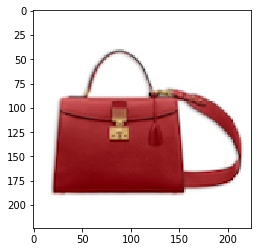

-----------------------------------------------------------------------
most similar products:


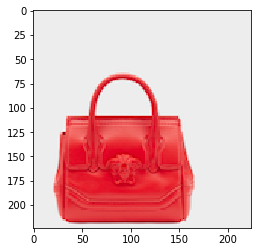

similarity score :  0.8263507


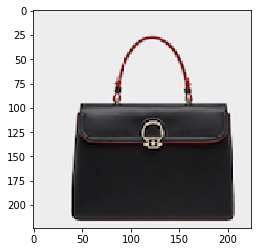

similarity score :  0.8238152


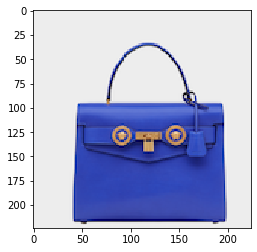

similarity score :  0.81619304


In [84]:
img_id = 213
get_k_most_similar_images(cos_sim_df, root_dir, all_image_ids[img_id])